In [1]:
# importacion de librerías
import tweepy
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import re

In [2]:
#Credenciales del Twitter API
consumer_key = "WcLuB376og30CYgeNcz3LFW88"
consumer_secret = "bWTmyjK9KPiFicaVFlmG6C6qdhT7jydtOsrs7o2Khf3Ybx2FrJ"
access_key = "1357711966228381696-a2Wcj8wSqMBt7qRwdCr2g1gfuSBmhQ"
access_secret = "2OKZC9XNEZaTVLGrkGgUE86qQzNNlZsGKjvh03A4Nh49m"

In [3]:
#Remover los caracteres no imprimibles y los saltos de línea del texto del tweet
def strip_undesired_chars(tweet):
    #eliminar saltos de línea
    stripped_tweet = tweet.replace('\n', ' ').replace('\r', '')
    #eliminar caracteres extendidos
    char_list = [stripped_tweet[j] for j in range(len(stripped_tweet)) if ord(stripped_tweet[j]) in range(65536)]
    stripped_tweet=''
    for char in char_list:
        stripped_tweet=stripped_tweet+char
    return stripped_tweet


In [4]:
def get_all_tweets(screen_name,lang):
    #Solicitar autorización a la app
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)   
    #Inicializar arreglo vacío para descargar los tweets
    alltweets = []
    #Solicito descargar los primeros 50 tweets
    new_tweets = api.user_timeline(screen_name = screen_name,count=50)  
    #Agregar los primeros 50
    alltweets.extend(new_tweets)   
    
    #Iniciamos el ciclo de descarga de los tweets
    while len(new_tweets) < len(alltweets): #<= limit_number:    
        #Traer tweets a partir del último descargado
        new_tweets = api.user_timeline(screen_name = screen_name,count=50)       
        #agregar los tweets descargados
        alltweets.extend(new_tweets)      
  
    df = pd.DataFrame(columns = ['id','created_at','text','retweet_count','likes','sentiment'])
    for tweet in alltweets:
            # Aplicación de función strip definida
            tweett = strip_undesired_chars(tweet.text)
            # Eliminamos la @ y su mención
            tweett = re.sub(r"@[A-Za-z0-9]+", ' ', tweett)
            # Eliminamos los hashtags y su mención
            tweett = re.sub(r"#[A-Za-z0-9]+", ' ', tweett)
            # Eliminamos los links de las URLs
            tweett = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweett)
            tweett = tweett.strip()
            tweett = tweett.lower()
            tweett = re.sub('rt', '', tweett)
            tweett = re.sub('_cl:','',tweett)
            # Verificar que el cuerpo del tweet sea no vacio
            tweett = tweett.strip()
            if tweett != " ":
              if  len(tweett) > 10:
                df = df.append({'id' : tweet.id_str, 
                                'created_at' : tweet.created_at, 
                                'text' : tweett ,
                                'retweet_count':tweet.retweet_count,
                                'likes':tweet.favorite_count
                                },ignore_index = True)  
          
    if lang == 1:
        # Se crea una lista auxiliar
        lista = list(df['text'])
        result = []
        for x in lista:
          # Se traducen los elementos de la lista
          result.append(TextBlob(x).translate(to='en'))

        # Se añaden los elementos al dataframe
        df_aux = pd.DataFrame(data = [row.split() for row in result[0:]])
        df['text'] = pd.Series(df_aux.fillna('').values.tolist()).str.join(' ')
        return df

    else:
        return df

In [5]:
def main_function(usuario,idioma):
      # call a la función de retorno
      df = get_all_tweets(usuario,idioma)

      # Obtener Sentimiento del Tweet
      df['sentiment'] = df['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

      # Obtener Ojetividad/Subjetividad del Tweet
      df['subjectivity'] = df['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment.subjectivity))
      
      if idioma == 1:
        # Se crea una lista auxiliar
        lista = list(df['text'])
        result = []
        for x in lista:
          # Se traducen los elementos de la lista
          result.append(TextBlob(x).translate(to='es'))

        # Se añaden los elementos al dataframe
        df_aux = pd.DataFrame(data = [row.split() for row in result[0:]])
        df['text'] = pd.Series(df_aux.fillna('').values.tolist()).str.join(' ')

      # definición de subjetivdad
      sub = df['subjectivity'] > 0.5
      sub = len(df[sub])

      obj = df['subjectivity'] <= 0.5
      obj = len(df[obj])

      # Prints
      print("")
      print("")
      print("Cantidad de Tweets Analizados: ",len(df))

      #Graficando Objetividad/Subjetividad
      labels = 'Subjetivo', 'Objetivo'
      sizes = [sub,obj]
      colors = ['gold', 'yellowgreen']
      explode = (0.1, 0)  # explode 1st slice
      plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
      plt.axis('equal')
      plt.title("Subjetividad de Tweets \n del usuario: " + usuario, bbox={'facecolor':'0.8', 'pad':5})
      plt.show()

      #Graficando Likes Sentiment
      fig, ax = plt.subplots()
      plt.xlabel("polaridad sentimiento")
      plt.ylabel("likes")
      plt.title("Cantidad de Likes en base al Sentimiento",fontsize=15)
      ax.scatter(df.sentiment, df.likes)
      plt.show()

      #Graficando Retweets Sentiment
      fig, ax = plt.subplots()
      plt.xlabel("polaridad sentimiento")
      plt.ylabel("retweets")
      plt.title("Cantidad de Retweets en base al Sentimiento",fontsize=15)
      ax.scatter(df.sentiment, df.retweet_count)
      plt.show()

      #Graficando Retweets Likes
      fig, ax = plt.subplots()
      plt.ylabel("retweets")
      plt.xlabel("likes")
      plt.title("Correlación entre Likes y Retweets",fontsize=15)
      ax.scatter(df.likes,df.retweet_count)
      plt.show()

      return df

<<<<Formulario para Ramificación de Errores>>>>

Si el idioma de los Tweets publicados por el usuario a buscar son en:
Ingles, teclee 0// Otro idioma, teclee 1
SALIR Y MOSTRAR WORDCLOUD, teclee 2
Teclee: 0
nombre del usuario en Twitter: elonmusk


Cantidad de Tweets Analizados:  39


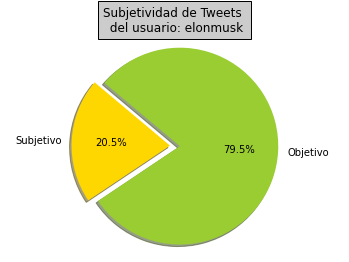

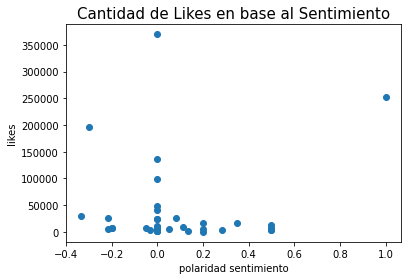

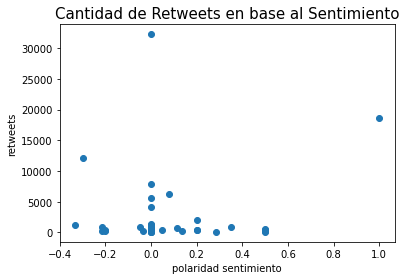

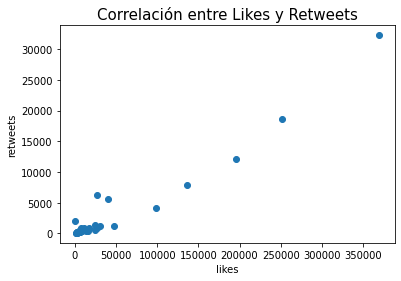


Si el idioma de los Tweets publicados por el usuario a buscar son en:
Ingles, teclee 0// Otro idioma, teclee 1
SALIR Y MOSTRAR WORDCLOUD, teclee 2
Teclee: 2


In [8]:
# Se guarda el nombre de usuario de la cuenta a la cual se descargarán los tweets

salir = False
opcion = 0

print("<<<<Formulario para Ramificación de Errores>>>>")
while not salir:

  print("")
  print("Si el idioma de los Tweets publicados por el usuario a buscar son en:")
  print("Ingles, teclee 0// Otro idioma, teclee 1")
  print("SALIR Y MOSTRAR WORDCLOUD, teclee 2")

  idioma = int(input("Teclee: "))

  if(idioma > 2):
    print("Entrada Inválida")
  elif idioma == 2:
    salir = True
  else:
    #cant = int(input("Ingrese cantidad promedio de Tweets a analizar: "))
    usuario = input("nombre del usuario en Twitter: ")
    df = main_function(usuario,idioma)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(-0.5, 799.5, 499.5, -0.5)

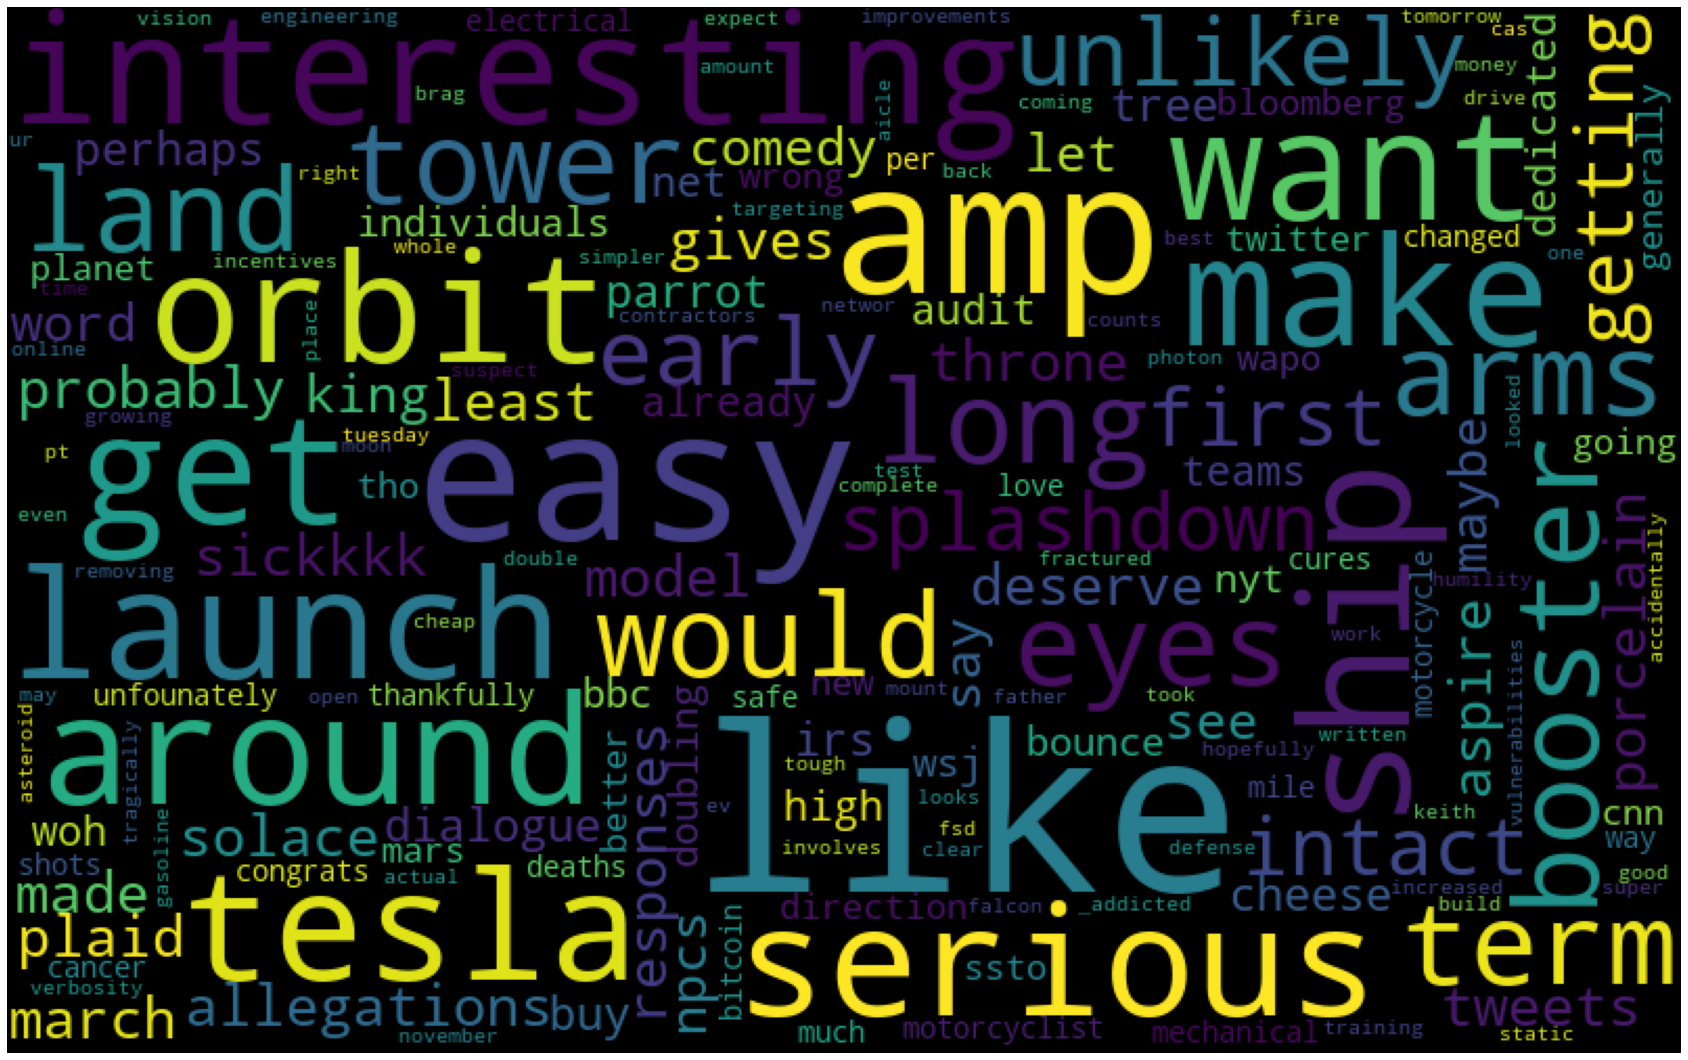

In [11]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from wordcloud import WordCloud 

all_words = ' '.join([text for text in df.text])
stopwords = stopwords.words("english")
#stopwords = set(stopwords.words('spanish', 'english')) 
#stopwords.update([ "de","pero","la","lo"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_words)

# Generar nube de palabras
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords = stopwords).generate(all_words)
# Impresion
plt.figure(figsize=(30, 20))
plt.imshow(wordcloud)
plt.axis("off")